In [90]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
import sys
import json
sys.path.append('src/recommendation')
import matchings

from Dataset import Dataset
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, A2C, PPO, SAC, TD3, DDPG

from stable_baselines3.common.callbacks import BaseCallback

from CourseRecEnv import CourseRecEnv, EvaluateCallback

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
dataset = Dataset("config/dataset_V1.yaml")

In [116]:
[len(learner) for learner in dataset.learners]

[19,
 38,
 27,
 16,
 18,
 10,
 13,
 15,
 13,
 21,
 18,
 13,
 8,
 31,
 18,
 25,
 21,
 32,
 27,
 16,
 13,
 22,
 24,
 32,
 24,
 7,
 10,
 25,
 27,
 33,
 7,
 25,
 32,
 23,
 8,
 36,
 8,
 17,
 6,
 8,
 13,
 12,
 7,
 21,
 11,
 31,
 20,
 33,
 18,
 14]

In [109]:
env = CourseRecEnv(dataset, min_skills=1, max_skills=40, threshold=0.8, k=3)

In [112]:
dataset.learners[0]

[(12, 2),
 (9, 2),
 (15, 3),
 (1, 2),
 (6, 1),
 (5, 1),
 (19, 1),
 (27, 1),
 (25, 1),
 (8, 2),
 (24, 1),
 (45, 1),
 (18, 1),
 (11, 2),
 (0, 2),
 (13, 1),
 (7, 2),
 (2, 1),
 (36, 3),
 (4, 3),
 (31, 1),
 (16, 1),
 (21, 1),
 (42, 1),
 (22, 1),
 (41, 3),
 (33, 3),
 (10, 3),
 (28, 1),
 (35, 1)]

In [113]:
env.learner_to_obs(dataset.learners[0])

array([ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0, 15, 16,
        0, 18, 19,  0, 21, 22,  0, 24, 25,  0, 27, 28,  0,  0, 31,  0, 33,
        0, 35, 36,  0,  0,  0,  0, 41, 42,  0,  0, 45], dtype=int32)

In [93]:
check_env(env)

In [94]:
total_steps = 1000
eval_freq = 1000

SB_models = [(DQN, {"policy": "MlpPolicy"}),
    (A2C, {"policy": "MlpPolicy", "device":'cpu'} ),
    (PPO, {"policy": "MlpPolicy"})]

for SB_model, kwargs in SB_models:
    train_env = CourseRecEnv(dataset, k=5)
    eval_env = CourseRecEnv(dataset, k=5)    
    print(SB_model)
    
    eval_callback = EvaluateCallback(eval_env, eval_freq=eval_freq)

    model = SB_model(env = train_env, verbose=0, **kwargs)
    model.learn(total_timesteps=total_steps, callback=eval_callback)

<class 'stable_baselines3.dqn.dqn.DQN'>
1000 14.741258741258742
<class 'stable_baselines3.a2c.a2c.A2C'>
1000 23.07226107226107
<class 'stable_baselines3.ppo.ppo.PPO'>
1000 14.777389277389277
2000 14.777389277389277


In [107]:
recommendations = dict()
for i, learner in enumerate(eval_env.dataset.learners):
    eval_env.reset(learner=learner)
    done = False
    recommendations[i] = []
    while not done:
        obs = eval_env._get_obs()
        old_attractiveness = eval_env._get_info()["nb_applicable_jobs"]
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = eval_env.step(action)
        recommendations[i].append((action.item(), reward))

In [108]:
recommendations

{0: [(44, 39), (44, -1)],
 1: [(18, 41), (18, -1)],
 2: [(62, 39), (6, -1)],
 3: [(18, 62), (18, -1)],
 4: [(18, 19), (18, -1)],
 5: [(77, 13), (77, -1)],
 6: [(18, 19), (18, -1)],
 7: [(18, 48), (18, -1)],
 8: [(44, 42), (44, -1)],
 9: [(18, 59), (18, -1)],
 10: [(18, 52), (18, -1)],
 11: [(18, 26), (18, -1)],
 12: [(18, 68), (18, -1)],
 13: [(44, 31), (44, -1)],
 14: [(18, 74), (18, -1)],
 15: [(65, 48), (65, -1)],
 16: [(18, 44), (18, -1)],
 17: [(18, 45), (18, -1)],
 18: [(23, 0), (23, -1)],
 19: [(18, 48), (18, -1)],
 20: [(18, 23), (18, -1)],
 21: [(18, 42), (18, -1)],
 22: [(18, 57), (18, -1)],
 23: [(44, 1), (44, -1)],
 24: [(18, 71), (18, -1)],
 25: [(18, 43), (18, -1)],
 26: [(81, 24), (18, 43), (18, -1)],
 27: [(18, 30), (18, -1)],
 28: [(18, 75), (18, -1)],
 29: [(62, 52), (62, -1)],
 30: [(18, 61), (18, -1)],
 31: [(18, 51), (18, -1)],
 32: [(81, 15), (81, -1)],
 33: [(18, 44), (18, -1)],
 34: [(18, 51), (18, -1)],
 35: [(18, 23), (14, 9), (14, -1)],
 36: [(18, 62), (18, -

In [20]:
import csv
import sys
import json
import pandas as pd

from collections import Counter

sys.path.append('src/recommendation')
%load_ext autoreload
%autoreload 2
from Dataset import Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
dataset = Dataset("config/dataset_V1.yaml")

In [23]:
dataset.jobs_inverted_index.keys()

dict_keys([4, 11, 28, 12, 6, 8, 24, 25, 16, 1, 7, 5, 34, 21, 22, 9, 36, 42, 13, 18, 35, 3, 30, 2, 0, 19, 37, 33, 32, 23, 26, 15, 27, 17, 41, 10, 31, 45, 14, 20, 38, 43, 29, 44, 40, 39])

In [11]:
dataset.courses[51][0]

[(42, 2), (9, 2), (37, 2), (18, 1), (6, 1), (7, 1), (22, 2)]

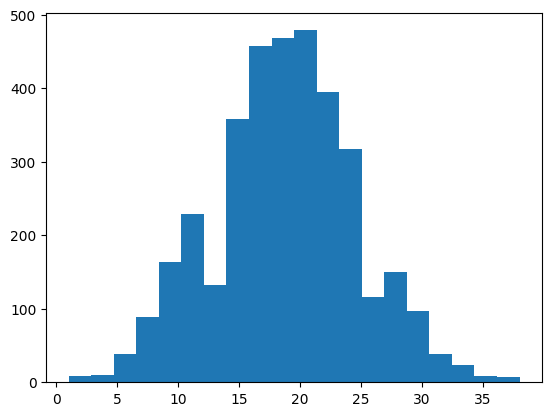

In [62]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(job) for job in dataset.jobs.values()], bins=20)
plt.show()

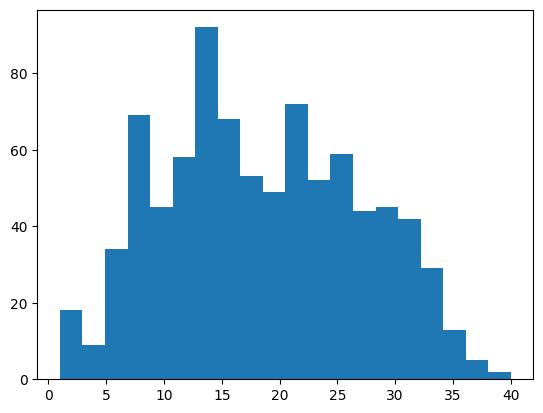

In [63]:
plt.hist([len(learner) for learner in dataset.learners.values()], bins=20)
plt.show()

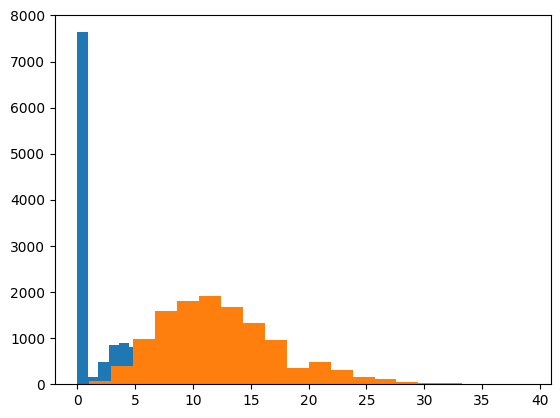

In [65]:
# plot the histogram of number of skills for jobs in dataset.jobs
import matplotlib.pyplot as plt
plt.hist([len(course["required_skills"]) for course in dataset.courses.values()], bins=20)
plt.hist([len(course["provided_skills"]) for course in dataset.courses.values()], bins=20)
plt.show()